# Data Extraction

In [1]:
import urllib.request as urllib2
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import csv

In [2]:
today = datetime.date.today()
mktcap_page = 'https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&amp;end='+"{:%Y%m%d}".format(today)
page = urllib2.urlopen(mktcap_page)
soup = BeautifulSoup(page, 'html.parser')
table = soup.find("table")

In [3]:
headings = [th.get_text().strip() for th in table.find("tr").find_all("th")]
headings

['Date', 'Open*', 'High', 'Low', 'Close**', 'Volume', 'Market Cap']

In [4]:
headings = [x.replace('*','') for x in headings]
headings

['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']

In [5]:
datasets = []

for row in soup.find_all("tr")[1:]:
    dataset = dict(zip(headings, (tr.get_text() for tr in row.find_all("td"))))
    if len(dataset) > 1:
        datasets.append(dataset)

datasets[0]

{'Close': '304.06',
 'Date': 'Jul 25, 2020',
 'High': '306.74',
 'Low': '279.03',
 'Market Cap': '34,027,002,730',
 'Open': '279.03',
 'Volume': '10,785,021,813'}

In [6]:
my_df = pd.DataFrame(datasets)
my_df.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Jul 25, 2020",279.03,306.74,279.03,304.06,"10,785,021,813","34,027,002,730"
1,"Jul 24, 2020",274.72,286.19,269.24,279.22,"9,466,060,358","31,243,266,716"
2,"Jul 23, 2020",262.39,277.58,261.05,274.69,"10,281,309,262","30,733,019,165"
3,"Jul 22, 2020",245.04,262.99,242.48,262.19,"7,702,077,383","29,331,058,164"
4,"Jul 21, 2020",236.30,246.19,235.68,245.02,"6,806,696,015","27,406,496,758"


In [7]:
full_data = my_df.set_index('Date')
#full_data = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']]
full_data.to_csv('full_data_eth_25072020.csv', index=True, header=True)

In [8]:
full_data.head(10)

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
"Jul 25, 2020",279.03,306.74,279.03,304.06,"10,785,021,813","34,027,002,730"
"Jul 24, 2020",274.72,286.19,269.24,279.22,"9,466,060,358","31,243,266,716"
"Jul 23, 2020",262.39,277.58,261.05,274.69,"10,281,309,262","30,733,019,165"
"Jul 22, 2020",245.04,262.99,242.48,262.19,"7,702,077,383","29,331,058,164"
"Jul 21, 2020",236.30,246.19,235.68,245.02,"6,806,696,015","27,406,496,758"
"Jul 20, 2020",238.49,239.58,234.85,236.15,"5,600,686,192","26,411,853,756"
"Jul 19, 2020",235.46,239.16,233.28,238.49,"6,251,377,305","26,669,691,075"
"Jul 18, 2020",232.86,236.54,232.32,235.48,"5,397,402,117","26,330,601,164"
"Jul 17, 2020",233.69,234.42,232.11,232.77,"5,859,850,529","26,024,301,468"


In [9]:
full_data.shape

(1815, 6)

In [10]:
full_data.dtypes

Open          object
High          object
Low           object
Close         object
Volume        object
Market Cap    object
dtype: object

In [11]:
def obj_to_int(x):
    x = x.replace(',','')
    return float(x)
full_data['Low'] = full_data['Low'].apply(obj_to_int)
full_data['High'] = full_data['High'].apply(obj_to_int)
full_data.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
"Jul 25, 2020",279.03,306.74,279.03,304.06,"10,785,021,813","34,027,002,730"
"Jul 24, 2020",274.72,286.19,269.24,279.22,"9,466,060,358","31,243,266,716"
"Jul 23, 2020",262.39,277.58,261.05,274.69,"10,281,309,262","30,733,019,165"
"Jul 22, 2020",245.04,262.99,242.48,262.19,"7,702,077,383","29,331,058,164"
"Jul 21, 2020",236.30,246.19,235.68,245.02,"6,806,696,015","27,406,496,758"


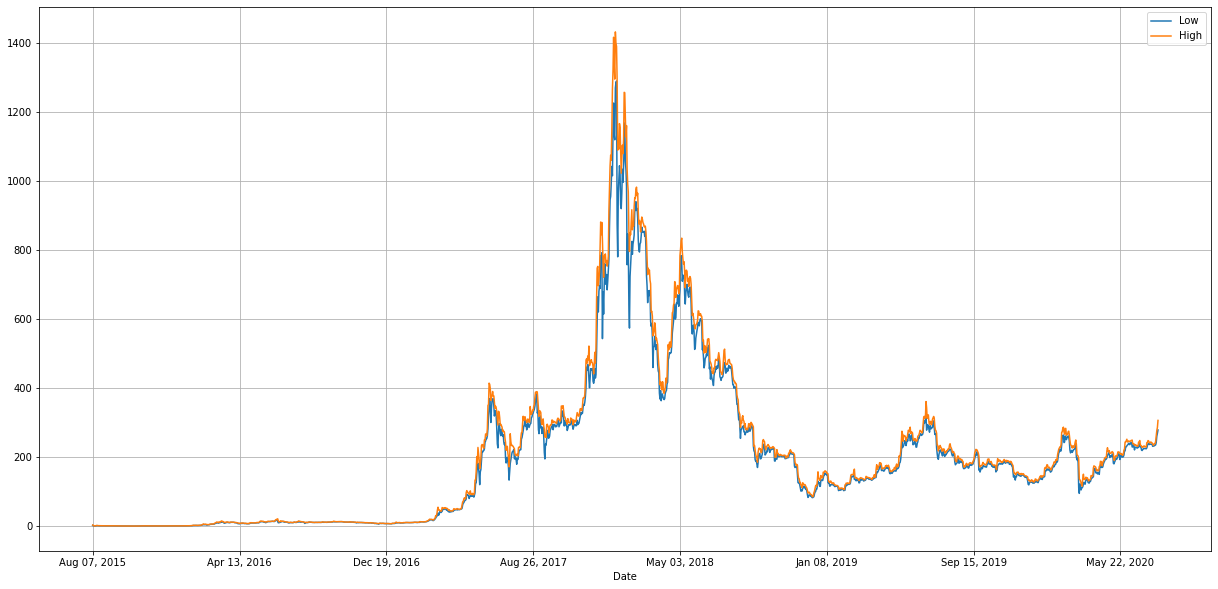

In [16]:
_= full_data[['Low','High']][::-1].plot(grid=True, figsize=(21, 10))

# Preparing data for time series

In [17]:
def obj_to_num(df,cols):
    def obj_to_num(row):
        if ',' in str(row):
          row = row.replace(',','')
          return float(row)
        else:
          return float(row)

    for col in cols: 
        df[col] = df[col].apply(obj_to_num) 
    return df
    
def prepare_data(file):
  dateparse = lambda x: pd.datetime.strptime(x, '%b %d, %Y').strftime('%Y-%m-%d')
  data  = pd.read_csv(file, parse_dates=[0], date_parser=dateparse)
  columns = ['Open','High','Low','Close','Volume','Market Cap']
  num_data = obj_to_num(data,columns)
  data['Date'] = data['Date'].dt.tz_localize(None)
  data = data.groupby([pd.Grouper(key='Date', freq='H')]).first().reset_index()
  data = data.set_index('Date')
  data = data[['High','Low']]
  data.dropna(subset=['High','Low'], inplace=True)
  return data

In [19]:
file = 'full_data_eth_25072020.csv'
data = prepare_data(file)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


,High,Low
Date,,
2015-08-07,3.540000,2.520000
2015-08-08,2.800000,0.714725
2015-08-09,0.879810,0.629191
2015-08-10,0.729854,0.636546
2015-08-11,1.130000,0.663235


In [20]:
data.index

DatetimeIndex(['2015-08-07', '2015-08-08', '2015-08-09', '2015-08-10',
               '2015-08-11', '2015-08-12', '2015-08-13', '2015-08-14',
               '2015-08-15', '2015-08-16',
               ...
               '2020-07-16', '2020-07-17', '2020-07-18', '2020-07-19',
               '2020-07-20', '2020-07-21', '2020-07-22', '2020-07-23',
               '2020-07-24', '2020-07-25'],
              dtype='datetime64[ns]', name='Date', length=1815, freq=None)

In [21]:
!pip install chart_studio

     |████████████████████████████████| 71kB 2.0MB/s 


In [22]:
import plotly.graph_objects as go
import chart_studio as py

import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [23]:
py.tools.set_credentials_file(username='xxxxxx', api_key='xxxxxxx')

In [24]:
trace1 = go.Scatter(
    x = data.index,
    y = data['High'].astype(float),
    mode = 'lines',
    name = 'swipe Price (High)'
)
trace2 = go.Scatter(
    x = data.index,
    y = data['Low'].astype(float),
    mode = 'lines',
    name = 'swipe Price (High)'
)

layout = dict(
    title='Historical swipe High price (USD) (...-2020)',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1,trace2]
fig = dict(data = data.copy(), layout=layout)
py.plotly.iplot(fig, filename = "Time Series with Rangeslider")

# Now the model

## To trade dayli we should know low and high prices on x number of days the closer the predictions are the more accurate result we have

In [25]:
!pip install pyramid-arima
from pyramid.arima import auto_arima

     |████████████████████████████████| 604kB 2.8MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.

/usr/local/lib/python3.6/dist-packages/pyramid/__init__.py:68: UserWarning:


    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https:/

In [26]:
# We do this again because the fo@#!ing pyplot plot changed data types 
file = 'full_data_eth_25072020.csv'
data = prepare_data(file)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



In [28]:
data.head()

,High,Low
Date,,
2015-08-07,3.540000,2.520000
2015-08-08,2.800000,0.714725
2015-08-09,0.879810,0.629191
2015-08-10,0.729854,0.636546
2015-08-11,1.130000,0.663235


In [39]:
data_high = pd.DataFrame(data['High'].copy())
data_high.head()

,High
Date,
2015-08-07,3.540000
2015-08-08,2.800000
2015-08-09,0.879810
2015-08-10,0.729854
2015-08-11,1.130000


In [40]:
stepwise_model = auto_arima(data_high, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=15265.381, BIC=15292.864, Fit time=22.569 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=16605.287, BIC=16616.281, Fit time=0.135 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=15991.526, BIC=16013.512, Fit time=5.471 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=15263.788, BIC=15285.775, Fit time=16.854 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=15264.652, BIC=15292.136, Fit time=21.596 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=16504.461, BIC=16520.951, Fit time=1.543 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=15264.608, BIC=15292.091, Fit time=41.217 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=15267.548, BIC=15300.528, Fit time=20.879 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=15351.354, BIC=15367.844, Fit time=8.717 seconds
Fit A

In [41]:
stepwise_model.aic()

15263.78810808924

In [42]:
train = data_high.loc['2015-08-07':'2020-07-24']
train.tail()

,High
Date,
2020-07-20,239.58
2020-07-21,246.19
2020-07-22,262.99
2020-07-23,277.58
2020-07-24,286.19


In [49]:
test = data_high.loc['2020-07-10':]
test.head()

,High
Date,
2020-07-10,242.88
2020-07-11,241.53
2020-07-12,243.31
2020-07-13,244.31
2020-07-14,242.00


In [50]:
len(test)

16

In [45]:
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 1),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 1, 1, 12), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend='c')

In [51]:
future_forecast = stepwise_model.predict(n_periods=17)

In [52]:
future_forecast

array([288.72571417, 290.9794319 , 290.48392412, 291.00391271,
       289.92324235, 290.63975423, 290.01143777, 290.19287422,
       289.24236602, 288.90866137, 287.49078771, 286.97599303,
       288.07896639, 290.3299145 , 289.83163709, 290.34885606,
       289.26541607])

In [53]:
test['Prediction'] = future_forecast[0:16].tolist()
test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,High,Prediction
Date,,
2020-07-10,242.88,288.725714
2020-07-11,241.53,290.979432
2020-07-12,243.31,290.483924
2020-07-13,244.31,291.003913
2020-07-14,242.00,289.923242
2020-07-15,241.40,290.639754
2020-07-16,239.01,290.011438
2020-07-17,234.42,290.192874
2020-07-18,236.54,289.242366
